# Hand-written digits recognition

In [1]:
%matplotlib inline

from keras import backend as K
from keras.layers import Dense
from keras.models import Model, Sequential
from keras.utils import to_categorical

from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Set bigger figures
plt.rcParams["figure.figsize"] = (15, 15)

## Digits dataset

This dataset is made up of 1797 8x8 images. Each image is a hand-written digit. In order to utilize an 8x8 figure like this, we had to first transform it into a feature vector of length 64.

## Train/Test division

Dataset is divided into train and test sets. Test set is used to evaluate overall performance of model after training. Data is split in a **stratified fashion**, using class labels as distribution.

## One-hot vector

Targets are transformed to one-hot vectors. One-hot vector is a vector with all '0' but one '1' at unique for each label index.

![one-hot vectors](refs/one-hot_vectors.jpg)

In [3]:
# Prepare data
digits = datasets.load_digits()

data_train, data_test, target_train, target_test = \
  train_test_split(digits.data, digits.target, test_size=0.2, random_state=7, stratify=digits.target)
_, n_features = digits.data.shape

# Prepare targets
onehot_train = to_categorical(target_train)
onehot_test = to_categorical(target_test)

## Data inspection

### Looking at images

It is always worth to look at your date to better understand it. Below we show 25 digits from our train set.

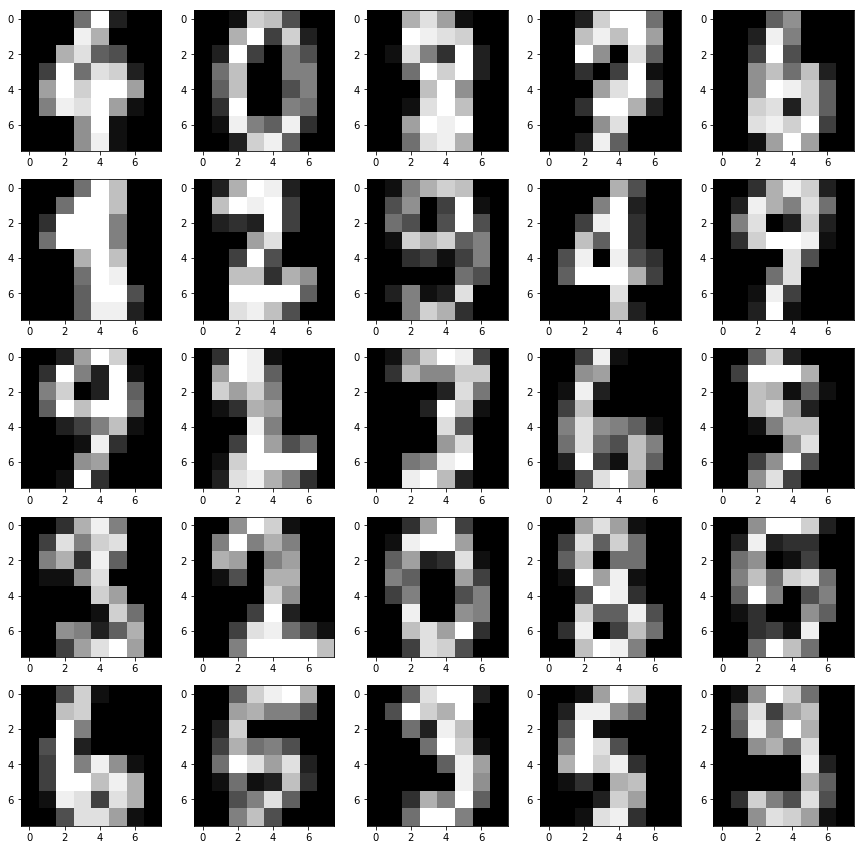

In [4]:
# Visualize data
IMAGE_SHAPE = (8, 8)
for i, image in enumerate(data_train[:25, :]):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image.reshape(IMAGE_SHAPE), cmap=plt.cm.gray)
plt.show()

### Visualization in low-dimensional representation

> t-Distributed Stochastic Neighbor Embedding (t-SNE) is a (prize-winning) technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets.

From: http://lvdmaaten.github.io/tsne/

#### You can see that:
* 3-s and 9-s are pretty similar,
* some 5-s look like 9-s,
* some 8-s look like 1-s,
* some 9-s look like 8-s,
* 6-s, 4-s, 0-s are easily distinguishable.

In [5]:
# Fit t-SNE 3D transformation on digits dataset
tsne = TSNE(n_components=3, random_state=7)
X_reduced = tsne.fit_transform(digits.data)
y = digits.target

# Fit t-SNE 2D transformation on digits dataset
tsne_2D = TSNE(n_components=2, random_state=7)
X_reduced_2D = tsne_2D.fit_transform(digits.data)

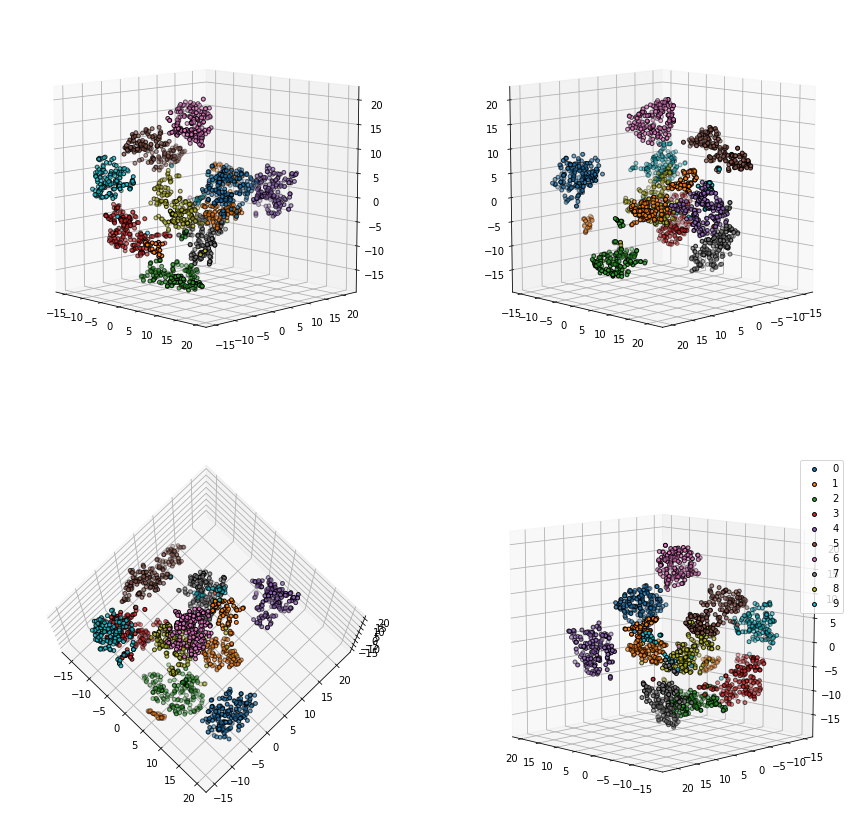

In [6]:
# Create 3D figure
fig = plt.figure(figsize=plt.figaspect(1.0))

ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.view_init(10, -45)
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax2.view_init(10, 45)
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax3.view_init(80, -45)
ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.view_init(10, 135)

# Scatter results
for i in range(len(digits.target_names)):
    ax1.scatter(X_reduced[y == i, 0], X_reduced[y == i, 1], X_reduced[y == i, 2],
                cmap=plt.cm.Set1, edgecolor='k', s=15, label=i)
    ax2.scatter(X_reduced[y == i, 0], X_reduced[y == i, 1], X_reduced[y == i, 2],
                cmap=plt.cm.Set1, edgecolor='k', s=15, label=i)
    ax3.scatter(X_reduced[y == i, 0], X_reduced[y == i, 1], X_reduced[y == i, 2],
                cmap=plt.cm.Set1, edgecolor='k', s=15, label=i)
    ax4.scatter(X_reduced[y == i, 0], X_reduced[y == i, 1], X_reduced[y == i, 2],
                cmap=plt.cm.Set1, edgecolor='k', s=15, label=i)

plt.legend()
plt.show()

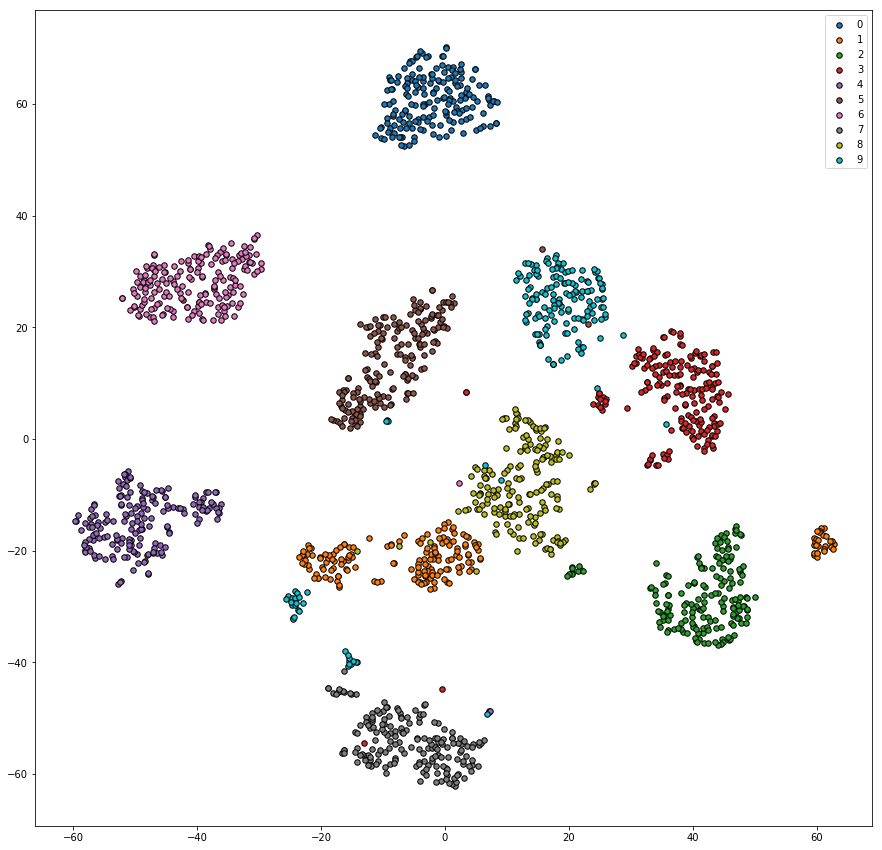

In [7]:
plt.figure()
for i in range(len(digits.target_names)):
    plt.scatter(X_reduced_2D[y == i, 0], X_reduced_2D[y == i, 1],
                cmap=plt.cm.Set1, edgecolor='k', s=30, label=i)
plt.legend()
plt.show()

### Neuron

![neuron](refs/neuron.jpg)

### Dense

![fully connected](refs/fully_connected_layer.png)

In dense layer (fully connected) **each neuron is connected to every neuron in previous layer**. For every connection there is one corresponding weight. To calculate neuron value we multiply inputs with corresponding weights and sum them together: $z_j = \sum_i x_i * w_{ji}$, and then we apply activation function $a_j = g(z_j)$. Activation function adds non-linearity to out computation, which allows us to model complex relations.

In [8]:
# Build model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_features,)))
model.add(Dense(10, activation='softmax'))

## Loss function

We need to measure how bad we are to get better. For classification problem we often interpret neural network output as unnormalized log probability of each class. We calculate probabilities with softmax function:

![softmax](refs/softmax.svg)

Then we use cross-entropy, to calculate how two distributions (predictions and targets) differ:

![cross entropy](refs/cross_entropy.svg)

## Gradient decent

When we know what is net loss, we now want to change each parameter in such a way, that will decrease its error. What tells us how to change parameters is gradient. As we change our parameters in the opposite direction to the gradient, we decrease loss. This algorithm is called gradient decent and it's very similar to blindly wandering in the mountains, searching for valley.

![gradient decent](refs/grad_descent_mountain.png)

## Optimizer

Computing gradient is not enough, we need to apply it somewhat. There are different ways to do this, one of them is momentum which we use.

### Learning rate

Learning rate tells us how big update should be: $w = w - \alpha * grad$.

![learning rate](refs/learning_rate.png)

### Momentum

Momentum simulates inertia of update: $v = \mu * v' - \alpha * grad, w = w + v$. With Momentum update, the parameter vector will build up velocity in any direction that has consistent gradient.

In [9]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

## Training

Use `model.fit(...)` method to train model for 25 epochs at max. Use validation split of 0.1.

In [10]:
model.fit(data_train, onehot_train, epochs=25, batch_size=64, validation_split=0.1)

Train on 1293 samples, validate on 144 samples
Epoch 1/25
1293/1293 [==============================] - 0s 184us/step - loss: 3.6008 - acc: 0.4308 - val_loss: 1.1946 - val_acc: 0.6806
Epoch 2/25
1293/1293 [==============================] - 0s 17us/step - loss: 0.5241 - acc: 0.8569 - val_loss: 0.5242 - val_acc: 0.8125
Epoch 3/25
1293/1293 [==============================] - 0s 16us/step - loss: 0.3065 - acc: 0.9064 - val_loss: 0.4306 - val_acc: 0.8542
Epoch 4/25
1293/1293 [==============================] - 0s 17us/step - loss: 0.2379 - acc: 0.9335 - val_loss: 0.2486 - val_acc: 0.9167
Epoch 5/25
1293/1293 [==============================] - 0s 18us/step - loss: 0.1904 - acc: 0.9381 - val_loss: 0.2152 - val_acc: 0.9375
Epoch 6/25
1293/1293 [==============================] - 0s 16us/step - loss: 0.1606 - acc: 0.9536 - val_loss: 0.1906 - val_acc: 0.9444
Epoch 7/25
1293/1293 [==============================] - 0s 20us/step - loss: 0.1350 - acc: 0.9629 - val_loss: 0.1859 - val_acc: 0.9375
Epoch 8

## Evaluate model

Use `model.evaluate(...)` method to evaluate model and print it's accuracy on test set.

In [11]:
# Evaluate model
# NOTE: Show evaluate docs and explain what we use and what it does
results = model.evaluate(data_test, onehot_test, batch_size=len(data_test), verbose=0)
print("\n[!] Evaluation results:")
print("{0}: {2:.3f}, {1}: {3:.3f}".format(*model.metrics_names, *results))


[!] Evaluation results:
loss: 0.138, acc: 0.956


## Visualize layers features

We use t-SNE to visualize processed digits after first (hidden) and last (output) neural net layer.

Further reading: https://distill.pub/2017/feature-visualization/

In [12]:
### Layers outputs ###

# Get first (hidden) layer activations for every digit
intermediate_model = Model(inputs=model.input, outputs=model.layers[0].output)
activations = intermediate_model.predict(digits.data)

# Get second (output) layer activations for every digit
intermediate_model = Model(inputs=model.input, outputs=model.layers[1].output)
outputs = intermediate_model.predict(digits.data)

### 3D ###

# Fit t-SNE 2D transformation on digits embeddings
A_reduced = tsne.fit_transform(activations)

# Fit t-SNE 2D transformation on digits embeddings
O_reduced = tsne.fit_transform(outputs)

### 2D ###

# Fit t-SNE 2D transformation on digits embeddings
A_reduced_2D = tsne_2D.fit_transform(activations)

# Fit t-SNE 2D transformation on digits embeddings
O_reduced_2D = tsne_2D.fit_transform(outputs)

### 3D

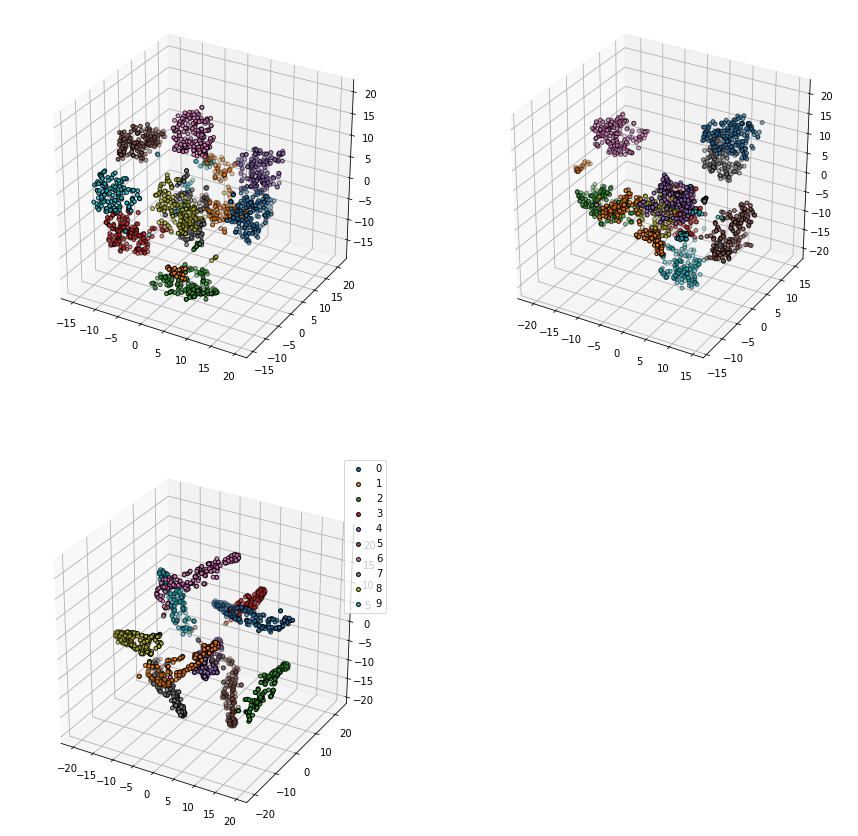

In [13]:
# Create 3D figure
fig = plt.figure(figsize=plt.figaspect(1.0))

ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax3 = fig.add_subplot(2, 2, 3, projection='3d')

# Scatter results
for i in range(len(digits.target_names)):
    ax1.scatter(X_reduced[y == i, 0], X_reduced[y == i, 1], X_reduced[y == i, 2],
                cmap=plt.cm.Set1, edgecolor='k', s=15, label=i)
    ax2.scatter(A_reduced[y == i, 0], A_reduced[y == i, 1], A_reduced[y == i, 2],
                cmap=plt.cm.Set1, edgecolor='k', s=15, label=i)
    ax3.scatter(O_reduced[y == i, 0], O_reduced[y == i, 1], O_reduced[y == i, 2],
                cmap=plt.cm.Set1, edgecolor='k', s=15, label=i)

plt.legend()
plt.show()

### 2D

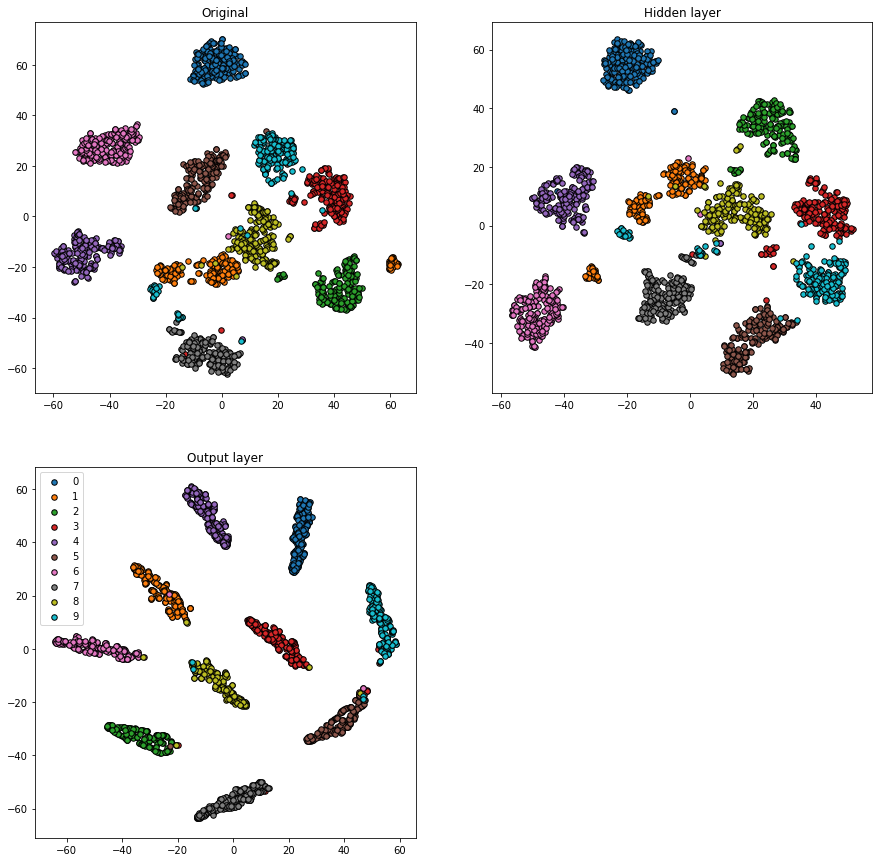

In [14]:
fig = plt.figure(figsize=plt.figaspect(1.0))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)

for i in range(len(digits.target_names)):
    ax1.set_title("Original")
    ax1.scatter(X_reduced_2D[y == i, 0], X_reduced_2D[y == i, 1],
                cmap=plt.cm.Set1, edgecolor='k', s=30, label=i)
    ax2.set_title("Hidden layer")
    ax2.scatter(A_reduced_2D[y == i, 0], A_reduced_2D[y == i, 1],
                cmap=plt.cm.Set1, edgecolor='k', s=30, label=i)
    ax3.set_title("Output layer")
    ax3.scatter(O_reduced_2D[y == i, 0], O_reduced_2D[y == i, 1],
                cmap=plt.cm.Set1, edgecolor='k', s=30, label=i)
    
plt.legend()
plt.show()